<a href="https://colab.research.google.com/github/dbenayoun/IASD/blob/main/2_distilbert_text_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Text classification using Transformers.
This lab will still focus on text classification on the Imdb dataset.
In this lab session, we will focus on encoder-based transformer architecture, through the lens of the most famous model: **BERT**.

---

# Introduction

## HuggingFace

We have already experimented with some components provided by the HuggingFace library:
- the `datasets` library,
- the `tokenizer`.

Actually, HuggingFace library provides convenient API to deal with transformer models, like BERT, GPT, etc.  To quote their website: *Transformers provides APIs and tools to easily download and train state-of-the-art pretrained models. Using pretrained models can reduce your compute costs, carbon footprint, and save you the time and resources required to train a model from scratch. Transformers support framework interoperability between PyTorch, TensorFlow, and JAX.*

## Goal of the lab session

We will experiment with the HuggingFace library. You'll have to load a model and to run it on your task.

Important things to keep in in minds are:
- Even if each model is a Transformer, they all have their peculiarities.
- What is the exact input format expected by the model?
- What is its exact output?
- Can you use the available model as is or should you make some modifications for your task?

These questions are actually part of the life of a NLP scientist. We will adress some of these questions in this lab and in the next lessons / labs / HW.

In [2]:
%%capture
!pip install transformers datasets

In [3]:
%matplotlib inline
%config InlineBackend.figure_formats = ['svg']
import matplotlib.pyplot as plt

from transformers import DistilBertTokenizer
from tqdm.notebook import tqdm


import numpy as np
import torch
import torch.nn.functional as F
import torch.nn as nn
import math
from torch.utils.data import DataLoader
from tabulate import tabulate
from datasets import load_dataset

from tqdm.notebook import tqdm

# If the machine you run this on has a GPU available with CUDA installed,
# use it. Using a GPU for learning often leads to huge speedups in training.
# See https://developer.nvidia.com/cuda-downloads for installing CUDA
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
DEVICE

device(type='cuda')

## Download the training data

In [4]:
dataset = load_dataset("scikit-learn/imdb", split="train")
print(dataset)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split: 0 examples [00:00, ? examples/s]

Dataset({
    features: ['review', 'sentiment'],
    num_rows: 50000
})


## Prepare model inputs

The input format to BERT looks like it is  "over-specified", especially if you focus on just one type task: sequence classification, word tagging, paraphrase detection, ...  The format:
- Add special tokens to the start and end of each sentence.
- Pad & truncate all sentences to a single constant length.
- Explicitly differentiate real tokens from padding tokens with the "attention mask".

It looks like that:

<img src="https://drive.google.com/uc?export=view&id=1cb5xeqLu_5vPOgs3eRnail2Y00Fl2pCo" width="600">

If you don't want to recreate this kind of inputs with your own hands, you can use the pre-trained tokenizer associated to BERT. Moreover the function `encode_plus` will:
- Tokenize the sentence.
- Prepend the `[CLS]` token to the start.
- Append the `[SEP]` token to the end.
- Map tokens to their IDs.
- Pad or truncate the sentence to `max_length`
- Create attention masks for `[PAD]` tokens.


> 💡 *Note:* For computational reasons, we will use the [DistilBERT](https://huggingface.co/docs/transformers/model_doc/distilbert) model, which is a 40% smaller than the original BERT model but still achieve about 95% of the performances of the original model.

In [5]:
tokenizer = DistilBertTokenizer.from_pretrained(
    "distilbert-base-uncased", do_lower_case=True
)

tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

Let's see how the tokenizer actually process the sequence:

In [6]:
# Some useful steps:
message = "hello my name is kevin"
tok = tokenizer.tokenize(message)
print("Tokens in the sequence:", tok)
enc = tokenizer.encode(tok)
table = np.array(
    [
        enc,
        [tokenizer.ids_to_tokens[w] for w in enc],
    ]
).T
print("Encoded inputs:")
print(tabulate(table, headers=["Token IDs", "Tokens"], tablefmt="fancy_grid"))

Tokens in the sequence: ['hello', 'my', 'name', 'is', 'kevin']
Encoded inputs:
╒═════════════╤══════════╕
│   Token IDs │ Tokens   │
╞═════════════╪══════════╡
│         101 │ [CLS]    │
├─────────────┼──────────┤
│        7592 │ hello    │
├─────────────┼──────────┤
│        2026 │ my       │
├─────────────┼──────────┤
│        2171 │ name     │
├─────────────┼──────────┤
│        2003 │ is       │
├─────────────┼──────────┤
│        4901 │ kevin    │
├─────────────┼──────────┤
│         102 │ [SEP]    │
╘═════════════╧══════════╛


🚧 **Question** 🚧

You noticed special tokens like `[CLS]` and `[SEP]` in the sequence. Note how they were added automatically by HuggingFace.

- Why are there such special tokens?

**Answer**

TODO

## Data pre-processing

Usual data-processing for torch. Same as previous lab.

In [7]:
def preprocessing_fn(x, tokenizer):
    x["input_ids"] = tokenizer.encode(
        x["review"],
        add_special_tokens=False,
        truncation=True,
        max_length=256,
        padding=False,
        return_attention_mask=False,
    )
    x["labels"] = 0 if x["sentiment"] == "negative" else 1
    return x

In [8]:
n_samples = 2000  # the number of training example

# We first shuffle the data !
dataset = dataset.shuffle()

# Select 5000 samples
splitted_dataset = dataset.select(range(n_samples))

# Tokenize the dataset
splitted_dataset = splitted_dataset.map(
    preprocessing_fn, fn_kwargs={"tokenizer": tokenizer}
)


# Remove useless columns
splitted_dataset = splitted_dataset.select_columns(["input_ids", "labels"])

# Split the train and validation
splitted_dataset = splitted_dataset.train_test_split(test_size=0.2)

train_set = splitted_dataset["train"]
valid_set = splitted_dataset["test"]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [9]:
#define the tokenizer and the pading, uniform our tensor size
class DataCollator:
    def __init__(self, tokenizer):
        self.tokenizer = tokenizer

    def __call__(self, batch):
        # `batch` is a list of dictionary with keys "review_ids" and "label".
        features = self.tokenizer.pad(
            batch, padding="longest", max_length=256, return_tensors="pt"
        )
        return features

In [10]:
data_collator = DataCollator(tokenizer)

In [11]:
#create the batch
batch_size = 4

train_dataloader = DataLoader(
    train_set, batch_size=batch_size, collate_fn=data_collator
)
valid_dataloader = DataLoader(
    valid_set, batch_size=batch_size, collate_fn=data_collator
)
n_valid = len(valid_set)
n_train = len(train_set)

# Model from scratch

For this task, we will start from a randomly initialized model.

## Retrieve the architecture configuration

In HuggingFace, model's parameters are specified through a `config` file. It is a json-like object.

We can retrieve the one from the official model with the following code:

In [12]:
from transformers import DistilBertConfig

model_config = DistilBertConfig.from_pretrained("distilbert-base-uncased")
print(model_config)

#dim: dim of embeddings
#hiddendim: dim of matrix in forward


DistilBertConfig {
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "initializer_range": 0.02,
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "transformers_version": "4.38.2",
  "vocab_size": 30522
}



🚧 **Question** 🚧

Make sure you understand the parameters of the configuration.
- Which ones are task-agnostic parameters?
- Which ones are not?
- Why are there different parameters for different tasks?

**Answer**

TODO



---



Several architectures are available for DistilBert on HuggingFace, designed for a variety of NLP tasks. Though these interfaces are all built on top of a trained DistilBert model, each has different top layers and output types designed to accomodate their specific NLP task.  

Here is the current list of classes provided for fine-tuning:
* BertModel
* BertForMaskedLM
* BertForNextSentencePrediction
* BertForSequenceClassification
* BertForTokenClassification
* BertForQuestionAnswering

The documentation for these can be found under [here](https://huggingface.co/docs/transformers/model_doc/distilbert).




🚧 **TODO** 🚧

For our first experiment, we want to build from a standard stack of transformer layers, without any additional task-specific head.

Which architecture is the corresponding one?

Choose the right one and initialize the model below, with the config.

In [13]:
from transformers import DistilBertModel

bert = DistilBertModel(model_config)

In [14]:
print(bert)

DistilBertModel(
  (embeddings): Embeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (transformer): Transformer(
    (layer): ModuleList(
      (0-5): 6 x TransformerBlock(
        (attention): MultiHeadSelfAttention(
          (dropout): Dropout(p=0.1, inplace=False)
          (q_lin): Linear(in_features=768, out_features=768, bias=True)
          (k_lin): Linear(in_features=768, out_features=768, bias=True)
          (v_lin): Linear(in_features=768, out_features=768, bias=True)
          (out_lin): Linear(in_features=768, out_features=768, bias=True)
        )
        (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (ffn): FFN(
          (dropout): Dropout(p=0.1, inplace=False)
          (lin1): Linear(in_features=768, out_features=3072, bias=True)
          (lin2): Li

Just for curiosity's sake, we can browse all of the model's parameters by name here.

In the below cell, we printed out the names and dimensions of the weights for:

- The embedding layer
- The first of the twelve transformers
- The output layer.



In [15]:
# Get all of the model's parameters as a list of tuples.
params = list(bert.named_parameters())

In [16]:
print("The BERT model has {:} different named parameters.\n".format(len(params)))

print("==== Embedding Layer ====\n")

for p in params[0:4]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print("\n==== First Transformer Layer ====\n")

for p in params[4:20]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

The BERT model has 100 different named parameters.

==== Embedding Layer ====

embeddings.word_embeddings.weight                       (30522, 768)
embeddings.position_embeddings.weight                     (512, 768)
embeddings.LayerNorm.weight                                   (768,)
embeddings.LayerNorm.bias                                     (768,)

==== First Transformer Layer ====

transformer.layer.0.attention.q_lin.weight                (768, 768)
transformer.layer.0.attention.q_lin.bias                      (768,)
transformer.layer.0.attention.k_lin.weight                (768, 768)
transformer.layer.0.attention.k_lin.bias                      (768,)
transformer.layer.0.attention.v_lin.weight                (768, 768)
transformer.layer.0.attention.v_lin.bias                      (768,)
transformer.layer.0.attention.out_lin.weight              (768, 768)
transformer.layer.0.attention.out_lin.bias                    (768,)
transformer.layer.0.sa_layer_norm.weight                 

🚧 **TODO** 🚧

Test your bert
We can already try the model on the validation set. Before just look at the output of the model on one batch.
- Interpret the output.  
- Do you understand everything ?


In [17]:
batch = next(iter(train_dataloader)) #takes first item in dataloader.
print(batch)

{'input_ids': tensor([[ 1045,  2018,  2196,  ...,     0,     0,     0],
        [ 2065,  2017,  2064,  ...,     0,     0,     0],
        [ 1045,  2387,  1000,  ...,     0,     0,     0],
        [ 1996,  2273, 17325,  ...,  2003,  5262,  3772]]), 'labels': tensor([0, 0, 0, 1]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 1, 1]])}


In [18]:
batch = next(iter(train_dataloader)) #takes first item in dataloader.

input_ids = batch["input_ids"]
attention_mask = batch["attention_mask"]

output = bert(input_ids, attention_mask=attention_mask)
print(output["last_hidden_state"].shape)


torch.Size([4, 256, 768])


## Building a classifier

Our `bert` model is simply a stack of transformer layers. We would like to use it as a backbone for text classification.

🚧 **TODO** 🚧

Wraps the model into a classifier.

> 💡 *Hint*: Use the last hidden [CLS] vector representation to perform classification.

In [19]:
class DistilBertClassifier(nn.Module):
    def __init__(self, bert):
        super().__init__()
        self.bert = bert
        self.drop = nn.Dropout(0.3)
        self.linear = nn.Linear(768, 1, bias=False)

    def forward(self, input_ids, attention_mask, **kwargs):
        bert_output = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        hidden_state = bert_output["last_hidden_state"]  # (bs, seq_len, dim)
        cls_hidden_state = hidden_state[:,0 ,:]
        cls_hidden_state = self.drop(cls_hidden_state)
        output = self.linear(cls_hidden_state)
        return output

In [20]:
bert = DistilBertModel(model_config)
model = DistilBertClassifier(bert)
model.to(DEVICE)

DistilBertClassifier(
  (bert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
            (lin1): Li

🚧 **TODO** 🚧

Test your model on the batch.
Make sure it has the right shape.

In [21]:
out = model(
    input_ids=batch["input_ids"].cuda(), attention_mask=batch["attention_mask"].cuda() ###add the cuda()
)
print(out.shape)

torch.Size([4, 1])


In [22]:
out #proba for item in batch that the review is positive

tensor([[-0.1143],
        [ 0.0930],
        [-0.4084],
        [ 0.9425]], device='cuda:0', grad_fn=<MmBackward0>)

### Training

🚧 **TODO** 🚧

Train your model.
Make sure you track the following quantities per epoch:
- training loss
- training accuracy
- validation loss
- validation accuracy

In [23]:
def validation(model, valid_dataloader):
    total_size = 0
    acc_total = 0
    loss_total = 0
    criterion = nn.BCEWithLogitsLoss()
    model.eval()
    with torch.no_grad():
        for batch in tqdm(valid_dataloader):
            batch = {k: v.cuda() for k, v in batch.items()}
            input_ids = batch["input_ids"]
            labels = batch["labels"]
            attention_mask = batch["attention_mask"]
            preds = model(input_ids=input_ids, attention_mask=attention_mask)
            loss = criterion(preds.squeeze(), labels.float().squeeze())
            acc = (preds.squeeze() > 0) == labels
            total_size += acc.shape[0]
            acc_total += acc.sum().item()
            loss_total += loss.item()
    model.train()
    return loss_total / len(valid_dataloader), acc_total / total_size


validation(model, valid_dataloader)

  0%|          | 0/100 [00:00<?, ?it/s]

(0.6949430537223816, 0.555)

In [24]:
def training(model, n_epochs, train_dataloader, valid_dataloader, lr=5e-5):
    optimizer = torch.optim.AdamW(
        model.parameters(),
        lr=lr,
        eps=1e-08,
    )
    list_val_acc = []
    list_train_acc = []
    list_train_loss = []
    list_val_loss = []
    criterion = nn.BCEWithLogitsLoss()

    for e in range(n_epochs):
        # ========== Training ==========

        # Set model to training mode
        model.train()
        model.to(DEVICE)

        # Tracking variables
        train_loss = 0
        epoch_train_acc = 0
        for batch in tqdm(train_dataloader):
            batch = {k: v.to(DEVICE) for k, v in batch.items()}
            input_ids, attention_mask, labels = (
                batch["input_ids"],
                batch["attention_mask"],
                batch["labels"],
            )
            optimizer.zero_grad() #reset gradiant from previous calc
            # Forward pass
            outputs = model(input_ids=input_ids, attention_mask=attention_mask) #call the model
            loss = criterion(outputs.squeeze(), labels.squeeze().float()) #get the loss

            # Backward pass
            loss.backward()

            # Optimization
            optimizer.step()

            train_loss += loss.detach().cpu().item()
            acc = (outputs.squeeze() > 0) == labels.squeeze()
            epoch_train_acc += acc.float().mean().item()
        list_train_acc.append(100 * epoch_train_acc / len(train_dataloader))
        list_train_loss.append(train_loss / len(train_dataloader))

        # ========== Validation ==========

        l, a = validation(model, valid_dataloader)
        list_val_loss.append(l)
        list_val_acc.append(a * 100)
        print(
            e,
            "\n\t - Train loss: {:.4f}".format(list_train_loss[-1]),
            "Train acc: {:.4f}".format(list_train_acc[-1]),
            "Val loss: {:.4f}".format(l),
            "Val acc:{:.4f}".format(a * 100),
        )
    return list_train_loss, list_train_acc, list_val_loss, list_val_acc

In [25]:
bert = DistilBertModel(model_config)
model = DistilBertClassifier(bert)
model.to(DEVICE)

DistilBertClassifier(
  (bert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
            (lin1): Li

In [26]:
batch_size = 16

train_dataloader = DataLoader(
    train_set, batch_size=batch_size, collate_fn=data_collator
)
valid_dataloader = DataLoader(
    valid_set, batch_size=batch_size, collate_fn=data_collator
)
n_valid = len(valid_set)
n_train = len(train_set)

In [27]:
list_train_loss, list_train_acc, list_val_loss, list_val_acc = training(
    model, 3, train_dataloader, valid_dataloader
)

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

0 
	 - Train loss: 0.7535 Train acc: 51.0625 Val loss: 0.7066 Val acc:49.5000


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

1 
	 - Train loss: 0.6059 Train acc: 66.1250 Val loss: 0.5345 Val acc:71.7500


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

2 
	 - Train loss: 0.2477 Train acc: 90.0000 Val loss: 0.9275 Val acc:69.7500


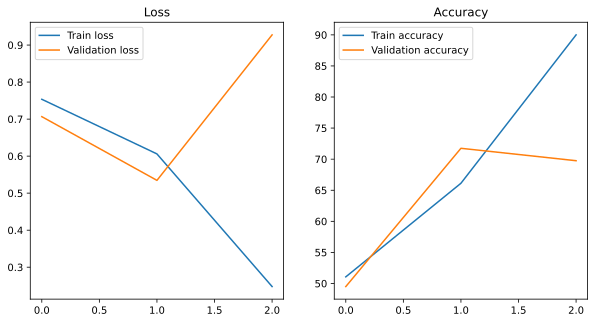

In [28]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[1].plot(list_train_acc, label="Train accuracy")
axs[1].plot(list_val_acc, label="Validation accuracy")
axs[0].plot(list_train_loss, label="Train loss")
axs[0].plot(list_val_loss, label="Validation loss")
axs[0].set_title("Loss")
axs[1].set_title("Accuracy")
axs[0].legend()
axs[1].legend()
plt.legend()
plt.show()

🚧 **Question** 🚧

How does it compare with your convolution model from previous lab?


## Pre-trained model

Now we are going to compare with a pre-trained model.

First, we are going to load the model's weights from the HuggingFace hub.

In [29]:
bert = DistilBertModel.from_pretrained("distilbert-base-uncased")
model = DistilBertClassifier(bert)
model.to(DEVICE)

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

DistilBertClassifier(
  (bert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
            (lin1): Li

## Fine-Tuning

With our model loaded and ready,  we need to grab the training hyperparameters from within the stored model.

For the purposes of fine-tuning, the authors recommend choosing from the following values (from Appendix A.3 of the [BERT paper](https://arxiv.org/pdf/1810.04805.pdf)):

- **Batch size:** 16, 32  
- **Learning rate (Adam):** 5e-5, 3e-5, 2e-5  
- **Number of epochs:** 2, 3, 4

We chose:
* Batch size: 16 (set when creating our DataLoaders)
* Learning rate: 5e-5
* Epochs: 3 (we'll see that this is probably too many...)

The epsilon parameter `eps = 1e-8` is "a very small number to prevent any division by zero in the implementation" (from [here](https://machinelearningmastery.com/adam-optimization-algorithm-for-deep-learning/)).

You can find the creation of the AdamW optimizer in `run_glue.py` [here](https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L109).

🚧 **TODO** 🚧

Build the classifier and train it with the pre-trained checkpoint.

In [30]:
list_train_loss, list_train_acc, list_val_loss, list_val_acc = training(
    model, 3, train_dataloader, valid_dataloader, lr=5e-6
)

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

0 
	 - Train loss: 0.6403 Train acc: 64.4375 Val loss: 0.4913 Val acc:78.5000


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

1 
	 - Train loss: 0.3610 Train acc: 85.6875 Val loss: 0.3329 Val acc:85.7500


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

2 
	 - Train loss: 0.2504 Train acc: 90.3125 Val loss: 0.3268 Val acc:85.0000


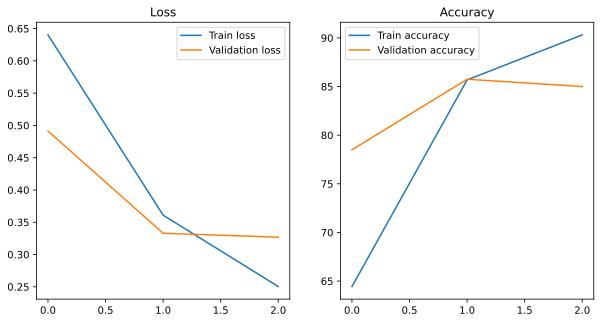

In [31]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[1].plot(list_train_acc, label="Train accuracy")
axs[1].plot(list_val_acc, label="Validation accuracy")
axs[0].plot(list_train_loss, label="Train loss")
axs[0].plot(list_val_loss, label="Validation loss")
axs[0].set_title("Loss")
axs[1].set_title("Accuracy")
axs[0].legend()
axs[1].legend()
plt.legend()
plt.show()

🚧 **Question** 🚧

What do you think of the results?

**Answer**

TODO

# Interpretability

So far we have models able to predict quite faithfully if a critic is positive or negative. But can we interprete the results?

A usual way to do so with transformers, is simply to look at the **attention weights**. Let's see if we can get some insights on the model's prediction using this technique.


First, tokenize the text.

In [32]:
text = (
    "captain corelli's mandolin is a beautiful film with a lovely cast"
    " including the wonderful nicolas cage, who as always is brilliant in the movie."
    " the music in the film is really nice too. i'd advise anyone to go and see it. brilliant! 10 / 10 "
)
tokenized_text = tokenizer(text, return_tensors="pt")

In [33]:
model.eval()

DistilBertClassifier(
  (bert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
            (lin1): Li

In [36]:
logits = model(input_ids=tokenized_text["input_ids"].cuda(), attention_mask=tokenized_text["attention_mask"].cuda())
out = torch.nn.functional.sigmoid(logits)

print("Probability that the review is positive is: ", out.item())

Probability that the review is positive is:  0.8916909098625183
